Sophia Ladyzhets, sal2213

Partner: Sally Green

## Temperature Modeling: Methods & Results

### Objective:

Create a model to predict the ground temperature at various stations in New York City based on measured temperature, wind speed, average rainfall, time of year, and ground composition (vegetated or concrete).

In [32]:
import requests
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt, dates as mdates
import datetime as datetime


In [33]:
#initialize necessary constants

#convective heat transfer
L = 80 
rho = 1.22
mu = 17.93*10**-6
k = .02557  ##assuming constant

Re_x = lambda u: rho * u * L / mu
Pr = .71

#solar radiation
alpha_qs = 200.0
sigma = 5.67*10**-8
epsilon = .85
T_sky = 280
T_g_ref = 300 ##place holder

# evaporative heat transfer
# evap_dict = {'March':1.19E-08, 'April':2.50E-08, 'May':2.65E-08, 'June':1.98E-08, 'July':1.53E-08, 'August':1.18E-08, 'September':2.99E-08}
#define evaporation constant d based on monthly precipitation data
# evap_dict = {3 : 1.19E-08, 4 : 2.50E-08, 5 : 2.65E-08, 6 : 1.98E-08, 7 : 1.53E-08, 8 : 1.18E-08, 9 : 2.99E-08}
evap_list = [1.19E-08, 2.50E-08, 2.65E-08, 1.98E-08, 1.53E-08, 1.18E-08, 2.99E-08]

# q = 2256 kJ/kg * 1000 kg/m^3 * 1 m * 1 m * d
q_evap = lambda d: (2256.0*10**6)*d

In [34]:
%run WeatherData_Fxns_SAL.py

### 1. Scrape data from Weather Underground station websites

The following code block has been commented out to prevent accidentally running the cell. The read_data_from_wu fxn is written in the "WeatherData_Fxns_SAL.py" file and is used to scrape data from weather underground (WU) websites and save the output in a .csv file.

In [35]:

# read_data_from_wu('KNYNEWYO343', '2021-07-01', '2021-07-07')
# read_data_from_wu('KNYNEWYO1421', '2021-07-01', '2021-07-07')
# read_data_from_wu('KNYNEWYO1335', start_date='2021-07-01', end_date='2021-07-07')   ##no data (all empty :/)
# read_data_from_wu('KNYNEWYO1238', start_date='2021-07-01', end_date='2021-07-07')   ##some data, some empty values --> let's try it!

#----- preliminary testing complete, now collecting data for July 2022 for 11 stations in NYC ------#

# read_data_from_wu('KNYNEWYO1421', '2022-07-01', '2022-07-31')  #1 complete
# read_data_from_wu('KNYNEWYO1622', '2022-07-01', '2022-07-31')   #2
# read_data_from_wu('KNYNEWYO1238', '2022-07-01', '2022-07-31')   #3
# read_data_from_wu('KNYNEWYO1626', '2022-07-01', '2022-07-31')  #4
# read_data_from_wu('KNYNEWYO1571', '2022-07-01', '2022-07-31')  #5
# read_data_from_wu('KNYNEWYO1300', '2022-07-01', '2022-07-31')  #6  ##6-8 are outside Manhattan
# read_data_from_wu('KNYNEWYO1651', '2022-07-01', '2022-07-31')  #7
# read_data_from_wu('KNYNEWYO1785', '2022-07-01', '2022-07-31')  #8 ##all nan values
# read_data_from_wu('KNYNEWYO1387', '2022-07-01', '2022-07-31')  #9
# read_data_from_wu('KNYNEWYO982', '2022-07-01', '2022-07-31')  #10
# read_data_from_wu('KNYNEWYO1615', '2022-07-01', '2022-07-31')  #11

#---------- now collecting data for 8 months --------------#

# specify date range for creating dataframes from csv
first_day='2022-03-01'
last_day='2022-10-31'

# wu_list = ['1421', '1622', '1238', '1626', '1571', '1300', '1651', '1387', '982', '1615']

# read_data_from_wu('KNYNEWYO1421', first_day, last_day)  #1 complete
# read_data_from_wu('KNYNEWYO'+wu_list[0], first_day, last_day)  
# read_data_from_wu('KNYNEWYO'+wu_list[1], first_day, last_day)  
# read_data_from_wu('KNYNEWYO'+wu_list[2], first_day, last_day)  
# read_data_from_wu('KNYNEWYO'+wu_list[3], first_day, last_day)   
# read_data_from_wu('KNYNEWYO'+wu_list[4], first_day, last_day)   
# read_data_from_wu('KNYNEWYO1300', '2022-07-01', '2022-07-31')  #6  ##6-7 are outside Manhattan
# read_data_from_wu('KNYNEWYO1651', '2022-07-01', '2022-07-31')  #7
# read_data_from_wu('KNYNEWYO'+wu_list[7], first_day, last_day)   
# read_data_from_wu('KNYNEWYO'+wu_list[8], first_day, last_day)
# read_data_from_wu('KNYNEWYO'+wu_list[9], first_day, last_day)

### 2. Load data from .csv into pandas dataframe

Now that the data has been scraped and saved in .csv files, it can be loaded and processed for analysis. We use the pandas library for all data processing.

The numbers in the wu_list refer to the stations at which we are measuring temperature and weather data. We use the wu_list throughout the data processing to iterate operations applied to all weather stations, such as removing strings and NaN values.


In [36]:
# redefine wu_list to remove stations with too much missing data
wu_list = ['1421', '1622', '1238', '1626',
           '1571', '1387', '982', '1615']


In [37]:
# load data from csv into pandas dataframes

data_0 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[0]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
                                                                                                                                                            # 'Wind Gust': str, 'Pressure': str,
                                                                                                                                                            # 'Precip.': str})
data_1 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[1]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_2 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[2]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_3 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[3]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_4 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[4]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
##temp load data_5 and data_6 as july only data since I don't have 8 mnths yet
# data_5 = data_1300
# data_6 = data_1651
data_5 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[5]+'_wunderground_'+first_day+'_'+last_day+'.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_6 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[6]+'_wunderground_'+first_day+'_'+'2022-08-16.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_7 = pd.read_csv('../aht_project/wu_data/KNYNEWYO'+wu_list[7]+'_wunderground_'+first_day+'_'+'2022-03-10.csv', converters={'Dew Point': str, 'Humidity': str, 'Speed': str})
data_0.dtypes


c:\Users\sophi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Time               object
Temperature        object
Dew Point          object
Humidity           object
Wind               object
Speed              object
Gust               object
Pressure           object
Precip. Rate.      object
Precip. Accum.     object
UV                float64
Solar              object
Date               object
dtype: object

In [38]:
data_0.head()

,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,UV,Solar,Date
0,NaN,NaN,,,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-01
1,12:04 AM,32.2 °F,--,32 °%,North,2.8 °mph,5.6 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01
2,12:09 AM,32.0 °F,--,31 °%,North,3.3 °mph,7.5 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01
3,12:14 AM,32.0 °F,--,30 °%,North,2.6 °mph,7.5 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01
4,12:19 AM,32.1 °F,--,30 °%,North,2.3 °mph,7.5 °mph,29.99 °in,--,--,NaN,w/m²,2022-03-01


In [39]:
weather_data_list = [data_0, data_1, data_2, data_3,
                     data_4, data_5, data_6, data_7]

# convert object types to strings, strip extra characters, and convert to floats

for i in range(len(weather_data_list)):
    weather_data_list[i] = weather_data_list[i].replace(to_replace='--', value=np.nan)
    weather_data_list[i] = weather_data_list[i].replace(to_replace='  ', value=np.nan)
    weather_data_list[i] = weather_data_list[i].replace(to_replace='', value=np.nan)
    weather_data_list[i] = weather_data_list[i].dropna(thresh=3)
    weather_data_list[i]['Temperature'] = weather_data_list[i]['Temperature'].str.strip(' \xa0°F')
    weather_data_list[i]['Temperature'] = weather_data_list[i]['Temperature'].astype(float)
    weather_data_list[i]['Speed'] = weather_data_list[i]['Speed'].astype(str)
    weather_data_list[i]['Speed'] = weather_data_list[i]['Speed'].str.strip(" °mph,' ")
    weather_data_list[i]['Speed'] = weather_data_list[i]['Speed'].astype(float)
    weather_data_list[i]['Humidity'] = weather_data_list[i]['Humidity'].astype(str)
    weather_data_list[i]['Humidity'] = weather_data_list[i]['Humidity'].str.strip(" °%',")
    weather_data_list[i]['Humidity'] = weather_data_list[i]['Humidity'].astype(float)
  


In [40]:
# read data from central park .csv into a separate dataframe and drop empty columns
central_park = pd.read_csv('Central Park Weather Data March to Sept 2022.csv')

central_park = central_park.replace(to_replace='--', value=np.nan)
central_park = central_park.dropna(thresh=3)
central_park = central_park.drop(
    ['STATION', 'NAME', 'PGTM', 'PGTM_ATTRIBUTES', 'TAVG',
     'TAVG_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES',  'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'TMAX_ATTRIBUTES'], axis=1)
central_park.head()


,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,TMAX,TMIN,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES
0,40.77898,-73.96925,42.7,2022-03-01,2.6,",,W",0.0,",,W,2400",0.0,",,W,2400",...,8.9,-0.5,180,",,W",200,",,W",6.3,",,W",10.7,",,W"
1,40.77898,-73.96925,42.7,2022-03-02,2.4,",,W",0.0,",,W,2400",0.0,",,W,2400",...,11.1,4.4,240,",,W",250,",,W",5.8,",,W",9.4,",,W"
2,40.77898,-73.96925,42.7,2022-03-03,4.3,",,W",0.8,",,W,2400",0.0,",,W,2400",...,8.9,-4.3,300,",,W",320,",,W",8.1,",,W",13.4,",,W"
3,40.77898,-73.96925,42.7,2022-03-04,2.4,",,W",0.0,",,W,2400",0.0,",,W,2400",...,2.8,-6.0,240,",,W",230,",,W",5.8,",,W",9.4,",,W"
4,40.77898,-73.96925,42.7,2022-03-05,1.6,",,W",0.0,",,W,2400",0.0,",,W,2400",...,7.8,0.0,160,",,W",130,",,W",5.8,",,W",9.4,",,W"


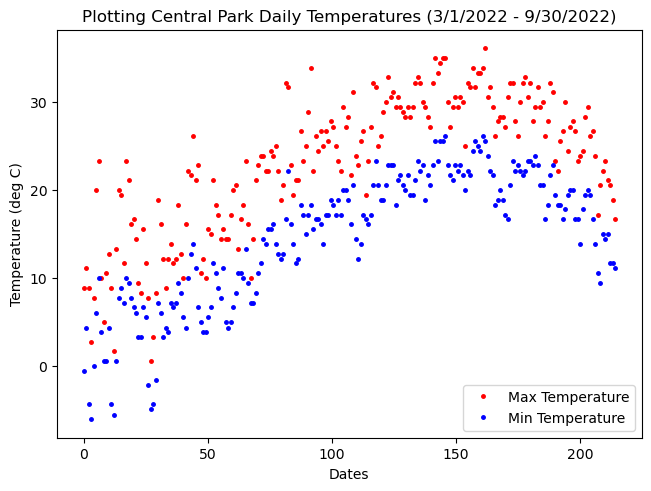

In [41]:
#plot minimum and maximum daily temperatures in Central Park
T_min_ctrl = central_park['TMIN']
x_min_ctrl = np.linspace(0.0, T_min_ctrl.shape[0], T_min_ctrl.shape[0])
T_max_ctrl = central_park['TMAX']
x_max_ctrl = np.linspace(0.0, T_max_ctrl.shape[0], T_max_ctrl.shape[0])

fig = plt.figure(constrained_layout = True)
ax = plt.gca()
ax.plot(x_max_ctrl, T_max_ctrl, 'ro', markersize=2.5, label='Max Temperature') 
ax.plot(x_min_ctrl, T_min_ctrl, 'bo', markersize=2.5, label='Min Temperature')  
ax.set_xlabel("Dates")
ax.set_ylabel("Temperature (deg C)")
ax.set_title('Plotting Central Park Daily Temperatures (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()

# We observe that data is present on every day and the trends generally look as we expect
# with higher temperatures in July and August compared to March, April, and September

### 3. Group WU data by max daily temperatures

#### Note on selection of max daily temperatures:

We ultimately decided to use only the max temperature value for each day for each weather station to build our heat transfer model.

Although this assumption reduced the amount of data we could use, it allowed us to greatly simplify the heat transfer model. We expect these temperatures to correspond to the peak solar radiation, which is 12 pm EST or EDT depending on the time of year. Thus, we could easily model the solar radiation absorbed by the ground, $q_{solar}$, and radiation from the ground to the sky, $q_{rad-to-sky}$, as a function of the time of year and latitutde and longtitude of New York City. 

We considered using minimum, mean, and maximum temperatures for our model. We also considered trying to combine hourly data to increase the number of data points used in our analysis; however, taking data from other times of data, especially night time, would require adding transient conditions to the heat transfer model to account for the heat dissipation from the ground to the sky at night. We decided that for the goal of analyzing heat transfer in dense, populated environments subject to the urban heat-island effect, a steady-state model using max daily temperatures would be much more useful than attempting to account for transient night-time effects.

In [42]:
# calculating min and max temp per day from WU data
# reference: https://github.com/arvindnswamy/IntroToPythonForMEstudents/blob/main/IntroductionToPython_PandasNumpyScipyMatplotlib.ipynb

wd_avgdailytemp_list = []
wd_mindailytemp_list = []
wd_maxdailytemp_list = []

for i in range(len(weather_data_list)):
    # group the data by mean, min, and max temperature on each date
    wd_dailytemp_avg = weather_data_list[i].groupby(by=['Date']).mean(['Temperature'])
    wd_dailytemp_min = weather_data_list[i].groupby(by=['Date']).min(['Temperature'])
    wd_dailytemp_max = weather_data_list[i].groupby(by=['Date']).max(['Temperature'])

    # convert temperatures from Fahrenheit to Celsius
    wd_dailytemp_avg['Temperature'][:] = (wd_dailytemp_avg['Temperature'][:] - 32.0 )*(5.0/9.0) 
    wd_dailytemp_min['Temperature'][:] = (wd_dailytemp_min['Temperature'][:] - 32.0 )*(5.0/9.0) 
    wd_dailytemp_max['Temperature'][:] = (wd_dailytemp_max['Temperature'][:] - 32.0)*(5.0/9.0)

    # assign the DATE values currently being used as an index to a column in the dataframe
    # this will allow us to combine the grouped wu datasets with the central park dataset
    wd_dailytemp_max = wd_dailytemp_max.assign(DATE=wd_dailytemp_max.axes[0])
    wd_avgdailytemp_list.append(wd_dailytemp_avg)
    wd_mindailytemp_list.append(wd_dailytemp_min)
    wd_maxdailytemp_list.append(wd_dailytemp_max)

print(wd_maxdailytemp_list[0].info())


<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 2022-03-01 to 2022-10-31
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     237 non-null    float64
 1   Dew Point       0 non-null      float64
 2   Humidity        237 non-null    float64
 3   Speed           237 non-null    float64
 4   Precip. Rate.   0 non-null      float64
 5   Precip. Accum.  0 non-null      float64
 6   UV              0 non-null      float64
 7   DATE            237 non-null    object 
dtypes: float64(7), object(1)
memory usage: 16.7+ KB
None


In [43]:
#calculating max temp per day from wu data again

wd_maxdailytemp_list = []

for i in range(len(weather_data_list)):
    wd_dailytemp_max = weather_data_list[i].groupby(by=['Date']).max(['Temperature'])
    wd_dailytemp_max['Temperature'][:] = (wd_dailytemp_max['Temperature'][:] - 32.0 )*(5.0/9.0)  #convert F to C
    wd_dailytemp_max['Speed'][:] = wd_dailytemp_max['Speed'][:]*0.44704  ## 1 mph = 0.44704 m/s
    wd_dailytemp_max = wd_dailytemp_max.assign(DATE=wd_dailytemp_max.axes[0])
    wd_dailytemp_max = wd_dailytemp_max.rename(columns={'Temperature': 'T_max'+wu_list[i], 'Humidity':'Rel_Humidity'+wu_list[i], 'Speed':'U_inf'+wu_list[i]})
    wd_maxdailytemp_list.append(wd_dailytemp_max)


In [44]:
# stations 3 and 6 were missing a significant amount of data, 
# so these stations were also removed from the combined dataframe
print(wd_maxdailytemp_list[3].info())
print(wd_maxdailytemp_list[6].info())


<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 2022-05-12 to 2022-10-31
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   T_max1626         172 non-null    float64
 1   Rel_Humidity1626  172 non-null    float64
 2   U_inf1626         172 non-null    float64
 3   UV                172 non-null    float64
 4   High              0 non-null      float64
 5   Low               0 non-null      float64
 6   Average           0 non-null      float64
 7   DATE              172 non-null    object 
dtypes: float64(7), object(1)
memory usage: 12.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 2022-03-01 to 2022-08-15
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   T_max982         156 non-null    float64
 1   Rel_Humidity982  156 non-null    float64
 2   U_inf982         156 non-null    float64
 3   UV     

In [45]:
#define new wu_list without stations 3 and 6
wu_list_n = ['1421', '1622', '1238', '1571', '1387']
wd_maxdailytemp_list_n = [wd_maxdailytemp_list[0], wd_maxdailytemp_list[1], wd_maxdailytemp_list[2], wd_maxdailytemp_list[4], wd_maxdailytemp_list[5]]

### 4. Merge Central Park data into one WU station dataframe

Merge the Central Park data into the datframe of one WU station, keeping the relevant columns.

In [46]:
# merge 
df_combo = pd.merge(wd_maxdailytemp_list[0], central_park, how='inner', on=['DATE'])
df_combo = df_combo.drop(['PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 
                          'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WSF2',
                          'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES', 'Dew Point'], axis=1)

df_combo = df_combo.rename(columns={'TMAX':'T_max_ctrl'})

# convert the temperature data for Central Park from Celsius to Kelvin
df_combo = df_combo.assign(T_max_ctrl_Kelv=df_combo['T_max_ctrl']+273.15)

### 5. Predict ground temperature for one station (constant $q_{solar}$)

Using the functions defined in "WeatherData_Fxns_SAL.py", we calculate a predicted value for the ground temperature on every row in the dataset. The introduction section of the report states the governing energy balance motivating this heat transfer model, and the methods provide derivations of the heat transfer equation for each mode of heat transfer.

For the first prediction, we assume a constant solar radiation regardless of the time of year.

In [47]:

# calculate the temperature difference between the weather station and Central Park
df_combo = df_combo.assign(Tdif0=df_combo['T_max'+wu_list_n[0]]-df_combo['T_max_ctrl'])
df_combo = df_combo.rename(columns={'Tdif0':'T_dif'+wu_list[0]})

# convert the temperature from Celsius to Kelvin
df_combo = df_combo.assign(T_Kelv=df_combo['T_max'+wu_list[0]]+273.15)  #Kelvin = 273.15 + deg C
df_combo = df_combo.rename(columns={'T_Kelv':'T_Kelv'+wu_list[0]})

# calculate the Reynold's number using the Re_x fxn and wind speed 
df_combo = df_combo.assign(Re=Re_x(df_combo['U_inf'+wu_list[0]]))
df_combo = df_combo.rename(columns={'Re':'Re'+wu_list[0]})

# use the q_convective fxn to calculate the convective heat transfer using the temperature in Kelvin 
# and wind speed U infinity
df_combo = df_combo.assign(q_conv=q_conv(df_combo['T_Kelv'+wu_list[0]],df_combo['U_inf'+wu_list[0]]))
df_combo = df_combo.rename(columns={'q_conv':'q_conv'+wu_list[0]})

# use the ground_temp fxn to calculate the predicted ground temperature 
# using the temperature in Kelvin and wind speed
df_combo = df_combo.assign(T_ground=ground_temp(
    df_combo['T_Kelv'+wu_list[0]], df_combo['U_inf'+wu_list[0]]))
df_combo = df_combo.rename(columns={'T_ground': 'T_ground'+wu_list[0]})


### 6. Repeat ground temperature prediction on all weather stations (constant $q_{solar}$)

This step iterates through all weather stations in the new weather underground station list, calculating the necessary values and merging columns into the single df_combo dataframe.

In [48]:

for i in range(1, len(wd_maxdailytemp_list_n)):
    df_combo = pd.merge(df_combo, wd_maxdailytemp_list_n[i], how='inner', on=['DATE'])
    df_combo = df_combo.assign(Tdif=df_combo['T_max'+wu_list_n[i]]-df_combo['T_max_ctrl'])
    df_combo = df_combo.rename(columns={'Tdif':'T_dif'+wu_list_n[i]})
    df_combo = df_combo.assign(T_Kelv=df_combo['T_max'+wu_list_n[1]]+273.15)
    df_combo = df_combo.rename(columns={'T_Kelv':'T_Kelv'+wu_list_n[i]})
    df_combo = df_combo.assign(Re=Re_x(df_combo['U_inf'+wu_list_n[i]]))
    df_combo = df_combo.rename(columns={'Re':'Re'+wu_list_n[i]})

    df_combo = df_combo.assign(q_conv=q_conv(df_combo['T_Kelv'+wu_list_n[i]],df_combo['U_inf'+wu_list_n[i]]))
    df_combo = df_combo.rename(columns={'q_conv':'q_conv'+wu_list_n[i]})

    df_combo = df_combo.assign(T_ground=ground_temp(df_combo['T_Kelv'+wu_list_n[i]], df_combo['U_inf'+wu_list_n[i]]))
    df_combo = df_combo.rename(columns={'T_ground': 'T_ground'+wu_list_n[i]})


df_combo = df_combo.drop(['Precip. Rate.', 'Precip. Accum.'], axis=1)
df_combo.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   T_max1421         200 non-null    float64
 1   Rel_Humidity1421  200 non-null    float64
 2   U_inf1421         200 non-null    float64
 3   UV_x              0 non-null      float64
 4   DATE              200 non-null    object 
 5   LATITUDE          200 non-null    float64
 6   LONGITUDE         200 non-null    float64
 7   ELEVATION         200 non-null    float64
 8   AWND              200 non-null    float64
 9   AWND_ATTRIBUTES   200 non-null    object 
 10  PRCP              200 non-null    float64
 11  T_max_ctrl        200 non-null    float64
 12  TMIN              200 non-null    float64
 13  T_max_ctrl_Kelv   200 non-null    float64
 14  T_dif1421         200 non-null    float64
 15  T_Kelv1421        200 non-null    float64
 16  Re1421            200 non-null    float64
 1

c:\Users\sophi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'UV_x'} in the result is deprecated and will raise a MergeError in a future version.
  


### 7. Calculate $q_{evap}$ for Central Park.

The approach to calculate the evaporative heat transfer also follows the equations outlined in the introduction and methods sections of the report.

In [49]:
#format the dates as datetime object to enable correct plotting

from datetime import datetime

df_combo['DATE'] = df_combo['DATE'].replace(to_replace='', value=np.nan)
df_combo['DATE'] = df_combo['DATE'].dropna()
df_combo['DATE'] = df_combo['DATE'].astype(str)
df_combo['DATE'] = df_combo['DATE'].str.strip(" ,''")
df_combo['DATE'] = pd.to_datetime(df_combo['DATE'], utc=True)

df_combo = df_combo.assign(MONTH=df_combo['DATE'].dt.month)
df_combo = df_combo.assign(DAY_INDEX=df_combo['DATE'].dt.dayofyear)
df_combo = df_combo.assign(evap_d=df_combo['MONTH'])
df_combo = df_combo.assign(Re_ctrl=Re_x(df_combo['AWND']))

df_combo['evap_d'] = np.where(df_combo['evap_d']== 3, 1.19E-08, 0.0)
df_combo['evap_d'] = np.where(df_combo['MONTH']== 4, 2.50E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 5, 2.65E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 6, 1.98E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 7, 1.53E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 8, 1.18E-08, df_combo['evap_d'])
df_combo['evap_d'] = np.where(df_combo['MONTH'] == 9, 2.99E-08, df_combo['evap_d'])

df_combo = df_combo.assign(q_evap_ctrl=q_evap(df_combo['evap_d']))
df_combo = df_combo.assign(T_ground_ctrl=ground_temp_ctrl(df_combo['T_max_ctrl_Kelv'], df_combo['AWND'],df_combo['evap_d']))
df_combo.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   T_max1421         200 non-null    float64            
 1   Rel_Humidity1421  200 non-null    float64            
 2   U_inf1421         200 non-null    float64            
 3   UV_x              0 non-null      float64            
 4   DATE              200 non-null    datetime64[ns, UTC]
 5   LATITUDE          200 non-null    float64            
 6   LONGITUDE         200 non-null    float64            
 7   ELEVATION         200 non-null    float64            
 8   AWND              200 non-null    float64            
 9   AWND_ATTRIBUTES   200 non-null    object             
 10  PRCP              200 non-null    float64            
 11  T_max_ctrl        200 non-null    float64            
 12  TMIN              200 non-null    float64            
 13  T_max

### 8. Repeat the ground temperature prediction (variable $q_{solar}$)

Now that we have properly assigned dates and months to each row of the dataframe, we can recalculate the expected solar radiation accounting for the time of year.
Then, we can make a new prediction for the ground temperature at all weather stations using the variable solar radiation function.

In [50]:
for i in range(0, len(wd_maxdailytemp_list_n)):
    df_combo = df_combo.assign(Tdif_ground=df_combo['T_ground'+wu_list_n[i]]-df_combo['T_ground_ctrl'])
    df_combo = df_combo.rename(columns={'Tdif_ground':'T_dif_ground'+wu_list_n[i]})
    # predict ground temperatures using variable solar radiation
    df_combo = df_combo.assign(T_ground_var=ground_temp_solar_var(df_combo['T_Kelv'+wu_list_n[i]], df_combo['U_inf'+wu_list_n[i]], df_combo['DAY_INDEX']))
    df_combo = df_combo.rename(columns={'T_ground_var': 'T_ground_var'+wu_list_n[i]})
    df_combo = df_combo.assign(T_ground_ctrl_var=ground_temp_ctrl_var(df_combo['T_max_ctrl_Kelv'], df_combo['AWND'], df_combo['evap_d'], df_combo['DAY_INDEX']))
    # calculate upper bound on q_solar using alpha = .7
    df_combo = df_combo.assign(T_ground_upper=ground_temp_solar_var(df_combo['T_Kelv'+wu_list_n[i]], df_combo['U_inf'+wu_list_n[i]], df_combo['DAY_INDEX'], alpha=.7))
    df_combo = df_combo.rename(columns={'T_ground_upper': 'T_ground_upper'+wu_list_n[i]})
    df_combo = df_combo.assign(T_ground_ctrl_upper=ground_temp_ctrl_var(df_combo['T_max_ctrl_Kelv'], df_combo['AWND'], df_combo['evap_d'], df_combo['DAY_INDEX'], alpha=.7))
    # calculate lower bound on q_solar using alpha = .5
    df_combo = df_combo.assign(T_ground_lower=ground_temp_solar_var(df_combo['T_Kelv'+wu_list_n[i]], df_combo['U_inf'+wu_list_n[i]], df_combo['DAY_INDEX'], alpha=.5))
    df_combo = df_combo.rename(columns={'T_ground_lower': 'T_ground_lower'+wu_list_n[i]})
    df_combo = df_combo.assign(T_ground_ctrl_lower=ground_temp_ctrl_var(df_combo['T_max_ctrl_Kelv'], df_combo['AWND'], df_combo['evap_d'], df_combo['DAY_INDEX'], alpha=.5))


## Plotting Results:

### 1. Plotting model input data

Here, we show plots for the inputs to our heat transfer model. These variables include air temperature data, wind speed, Reynold's number, humidity, and evaporative heat transfer.


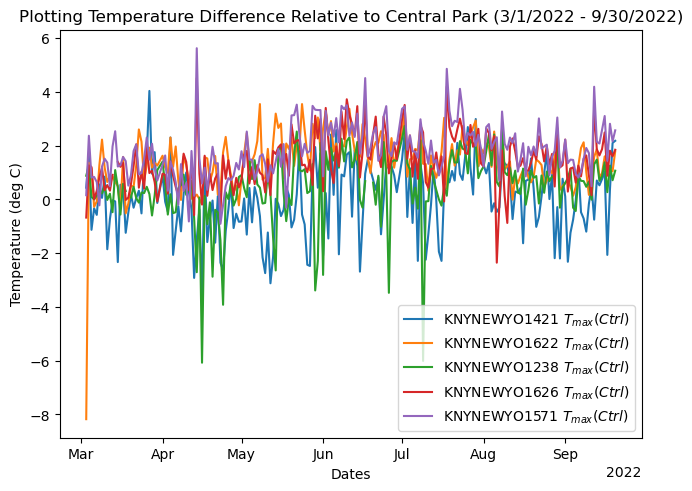

In [51]:
# plotting air temperature differences relative to Central Park

fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_dif'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{max} (Ctrl)$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel("Temperature (deg C)")
ax.set_title('Plotting Temperature Difference Relative to Central Park (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


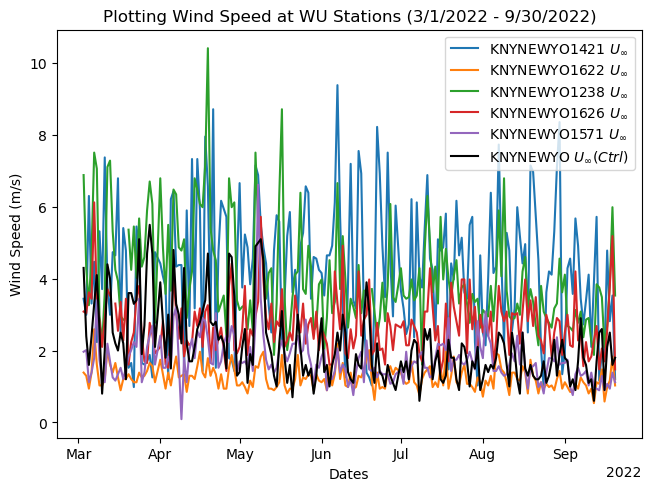

In [52]:
#plotting wind speed data
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $U_{\infty}$')  
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
# ax.plot(df_combo['DATE'], df_combo['U_inf'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $U_{\infty}$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['AWND'], '-k', markersize=2.5,
        label=r'KNYNEWYO $U_{\infty} (Ctrl)$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel("Wind Speed (m/s)")
ax.set_title('Plotting Wind Speed at WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='upper right')
plt.show()


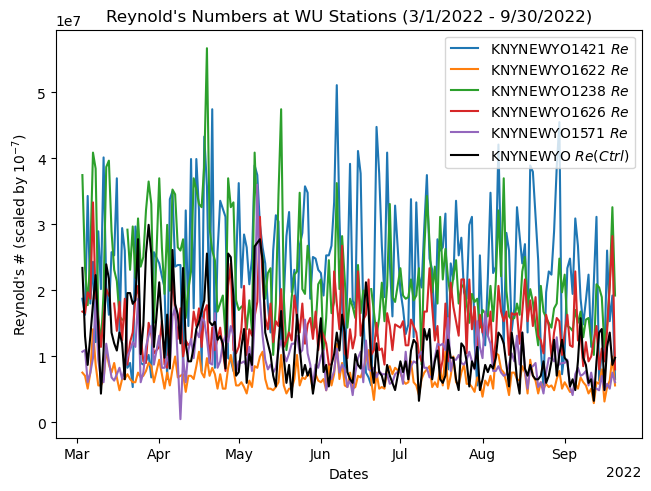

In [53]:
#plotting Reynold's #
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['Re'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $Re$')  
ax.plot(df_combo['DATE'], df_combo['Re_ctrl'], '-k', markersize=2.5,
        label=r'KNYNEWYO $Re (Ctrl)$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel(r"Reynold's # (scaled by $10^{-7}$)")
ax.set_title("Reynold's Numbers at WU Stations (3/1/2022 - 9/30/2022)")
plt.legend(loc='upper right')
plt.show()


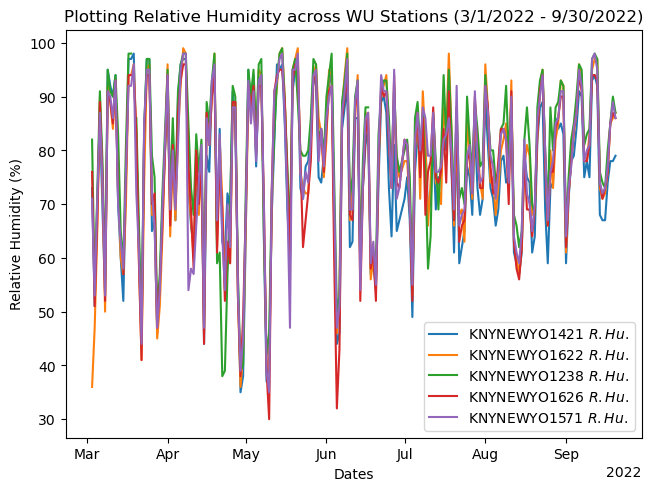

In [54]:
#plotting relative humidity data
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['Rel_Humidity'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $R. Hu.$')  
    
ax.set_xlabel("Dates")
ax.set_ylabel("Relative Humidity (%)")
ax.set_title('Plotting Relative Humidity across WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


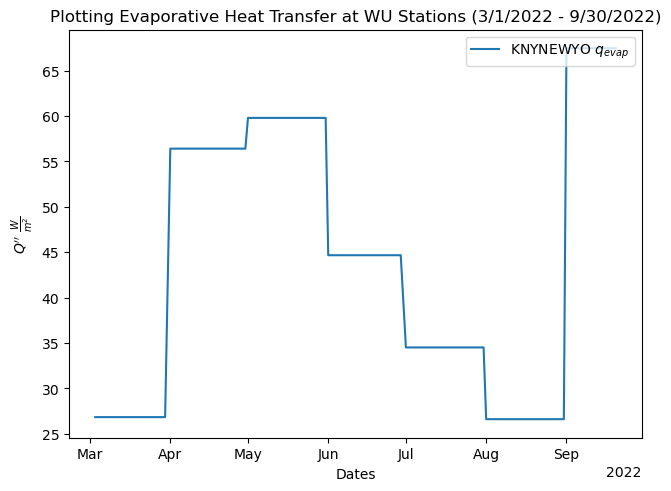

In [55]:
#plotting evaporative heat transfer by month in Central Park
fig = plt.figure(constrained_layout=True)
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(df_combo['DATE'], df_combo['q_evap_ctrl'], markersize=2.5, label=r'KNYNEWYO $q_{evap}$')  

ax.set_xlabel("Dates")
ax.set_ylabel(r"$Q''$ $\frac{W}{m^2}$")
ax.set_title('Plotting Evaporative Heat Transfer at WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='upper right')
plt.show()


### 2. Plotting model output predictions

These plots show the predicted ground temperature with both constant and variable solar radiation accounted for in the heat transfer model.

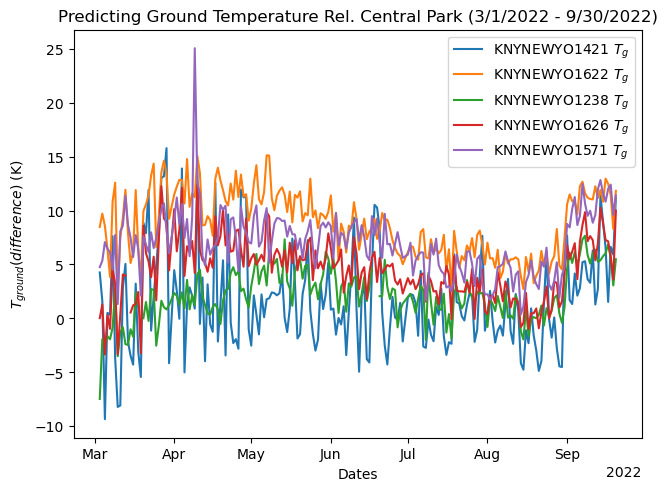

In [56]:
# plotting predicted ground temperatures at WU stations relative to predicted Central Park ground temperatures
# note: solar radiation is assumed to be constant
fig = plt.figure(constrained_layout=True)

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_dif_ground'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_g$')  

ax.set_xlabel("Dates")
ax.set_ylabel(r"$T_{ground}(difference)$ (K)")
ax.set_title('Predicting Ground Temperature Rel. Central Park (3/1/2022 - 9/30/2022)')
plt.legend(loc='upper right')
plt.show()


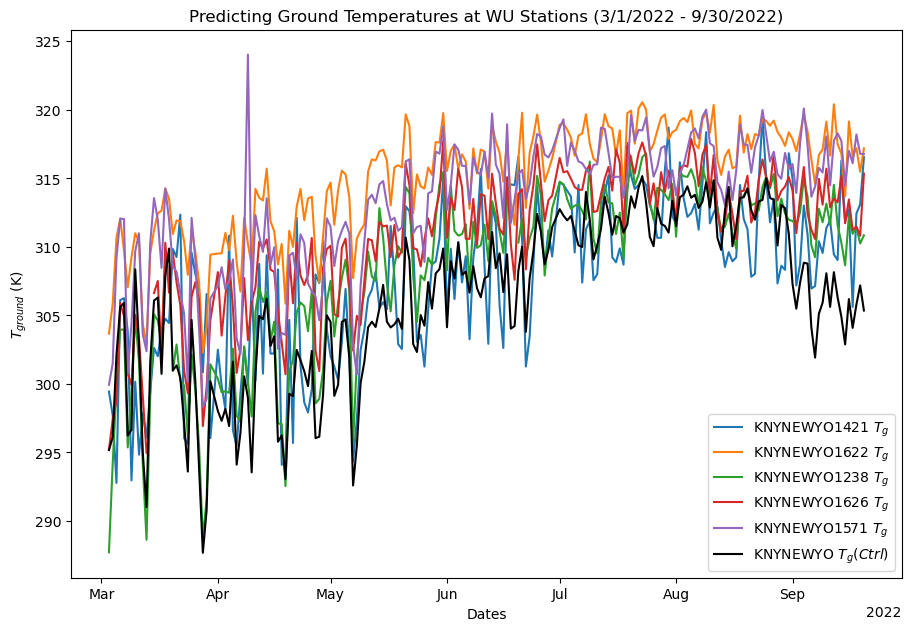

In [59]:
# plotting predicted ground temperatures with constant solar radiation

fig = plt.figure(constrained_layout=True, figsize=(9,6.2))
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_ground'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_g$')  
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  

ax.set_xlabel("Dates")
ax.set_ylabel(r"$T_{ground}$ (K)")
ax.set_title('Predicting Ground Temperatures at WU Stations (3/1/2022 - 9/30/2022)')
plt.legend(loc='lower right')
plt.show()


<Figure size 640x480 with 0 Axes>

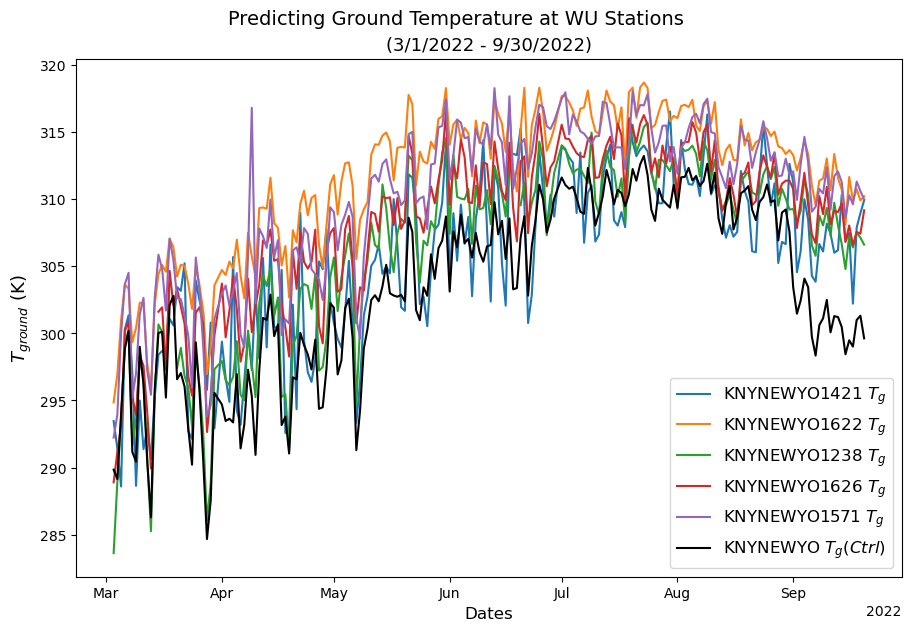

In [58]:
# plotting ground temperature predictions accounting for variable solar radiation
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(len(wu_list_n)):
    ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list_n[i]], markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$')  
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(3/1/2022 - 9/30/2022)', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
plt.show()


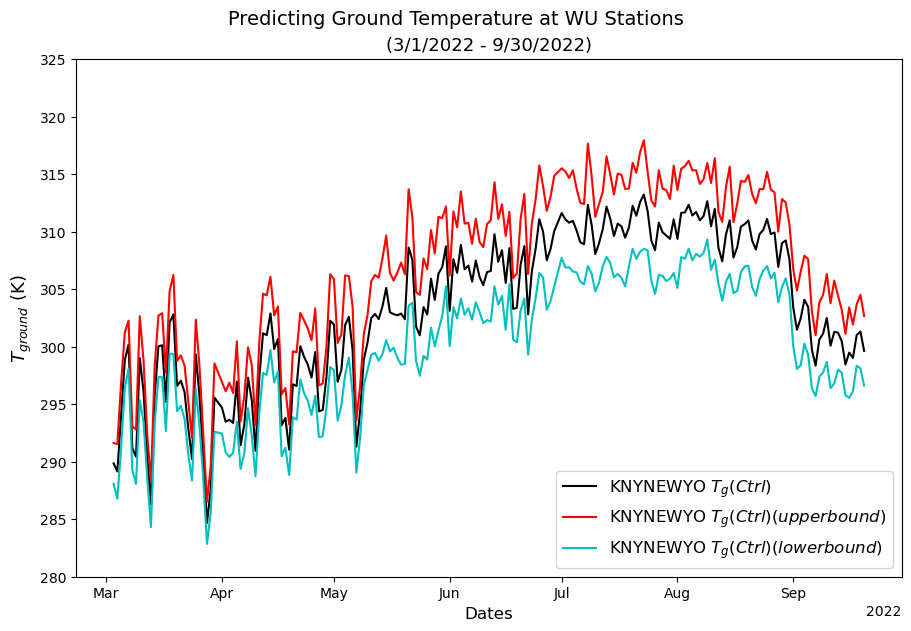

In [161]:
# plotting ground temperature predictions accounting for variable solar radiation -- plotting upper and lower bounds
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))
smooth = 1

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  
ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_ctrl_upper'][::smooth], '-r', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl) (upper bound)$')  
ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_ctrl_lower'][::smooth], '-c', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl) (lower bound)$')  
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(3/1/2022 - 9/30/2022)', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
ax.set_ylim(280,325)
plt.show()


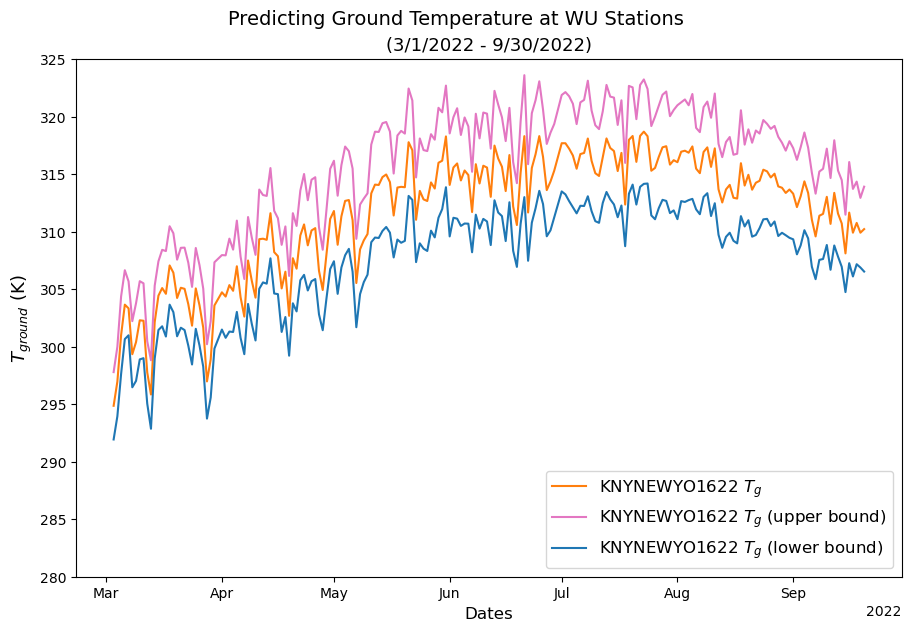

In [169]:
# plotting ground temperature predictions accounting for variable solar radiation -- plotting upper and lower bounds
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))
smooth = 1

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for i in range(1,2):
    ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list_n[i]], '-', color='tab:orange', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$')  
    ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_upper'+wu_list_n[i]][::smooth], '-',  color='tab:pink', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$ (upper bound)')  
    ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_lower'+wu_list_n[i]][::smooth], '-', color='tab:blue', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$ (lower bound)')  

    # ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_ctrl_upper'][::smooth], '-r', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl) (upper bound)$')  
    # ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_ctrl_lower'][::smooth], '-c', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl) (lower bound)$')  
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(3/1/2022 - 9/30/2022)', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
ax.set_ylim(280,325)
plt.show()


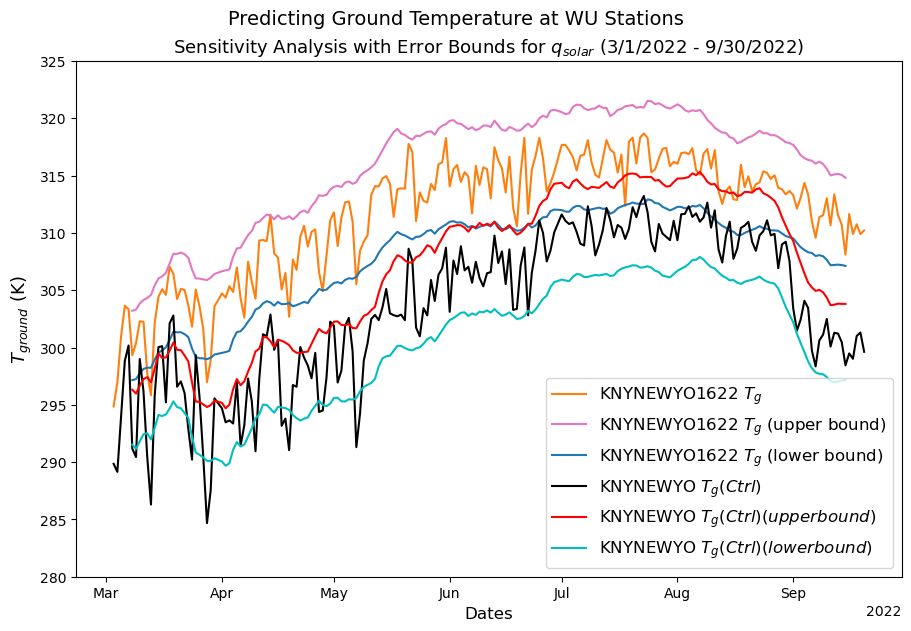

In [162]:
# plotting ground temperature predictions accounting for variable solar radiation -- plotting upper and lower bounds
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))
# smooth = 1
kernel_size = 10
snip = int(kernel_size/2)
kernel = np.ones(kernel_size)/kernel_size

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for i in range(1,2):
# for i in range(len(wu_list_n)-4):
    ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list_n[i]], '-', color='tab:orange', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$')  
    data_convolved_upper = np.convolve(df_combo['T_ground_upper'+wu_list_n[i]], kernel, mode='same')
    ax.plot(df_combo['DATE'][snip:-snip], data_convolved_upper[snip:-snip], '-', color='tab:pink', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$ (upper bound)')  
    # ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_upper'+wu_list_n[i]][::smooth], '-m', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$ (upper bound)')  
    data_convolved_lower = np.convolve(df_combo['T_ground_lower'+wu_list_n[i]], kernel, mode='same')
    ax.plot(df_combo['DATE'][snip:-snip], data_convolved_lower[snip:-snip], '-', color='tab:blue', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$ (lower bound)')  
    # ax.plot(df_combo['DATE'][::smooth], df_combo['T_ground_lower'+wu_list_n[i]][::smooth], '-b', markersize=2.5, label=r'KNYNEWYO'+wu_list[i]+' $T_{g}$ (lower bound)')  
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  
data_convolved_ctrl_upper = np.convolve(df_combo['T_ground_ctrl_upper'], kernel, mode='same')
ax.plot(df_combo['DATE'][snip:-snip], data_convolved_ctrl_upper[snip:-snip], '-r', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl) (upper bound)$')  
data_convolved_ctrl_lower = np.convolve(df_combo['T_ground_ctrl_lower'], kernel, mode='same')
ax.plot(df_combo['DATE'][snip:-snip], data_convolved_ctrl_lower[snip:-snip], '-c', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl) (lower bound)$')  
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title(r'Sensitivity Analysis with Error Bounds for $q_{solar}$ (3/1/2022 - 9/30/2022)', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
ax.set_ylim(280,325)
plt.show()


## Model Validation: Comparison to Historical Data

We will now calculate the predicted ground temperature on three dates in June, July, and August, 2022 and compare the predictions against historical ground temperature data from 2002.

In [170]:
# df_combo['DATE']
date_July = datetime.strptime("2022-07-22", "%Y-%m-%d")
date_August = datetime.strptime("2022-08-14", "%Y-%m-%d")
date_September = datetime.strptime("2022-09-08", "%Y-%m-%d")
July_1 = datetime.strptime('2022-07-01', "%Y-%m-%d")
Sept_30 = datetime.strptime('2022-09-30', "%Y-%m-%d")

<Figure size 640x480 with 0 Axes>

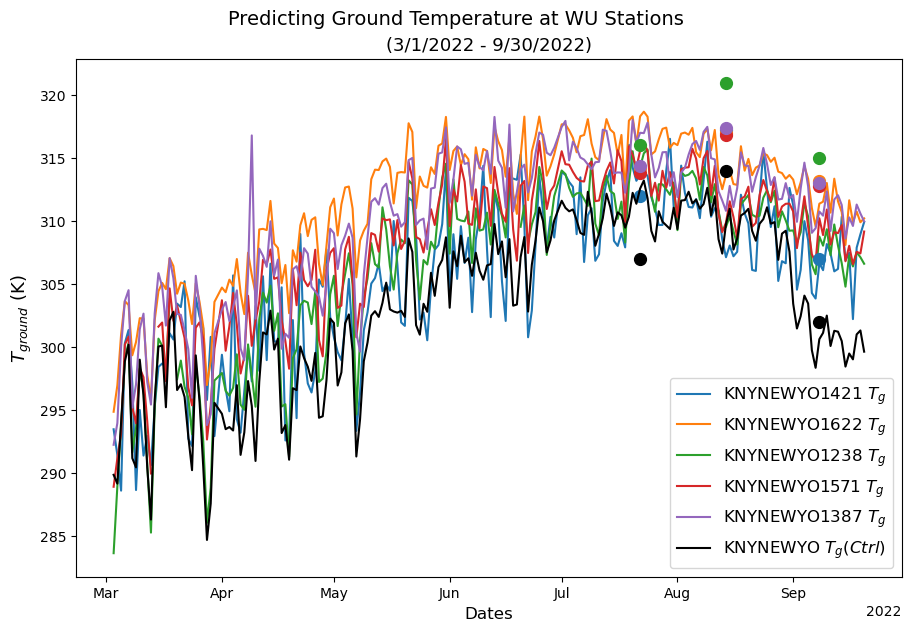

In [171]:
#plotting central park weather data
fig = plt.figure(constrained_layout=True)
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $T_g$')  ##close to Central Park (uptown - Harlem))
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[5]], markersize=2.5, label=r'KNYNEWYO'+wu_list[5]+' $T_g$')  # close to Central Park (uptown - Harlem))
# close to Central Park (uptown - Harlem))
ax.plot(date_July, 312.0, 'o', color='tab:blue', markersize=8.5)  # close to Central Park (uptown - Harlem))
ax.plot(date_July, 314.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_July, 316.0, 'o', color='tab:green', markersize=8.5) # close to Central Park (uptown - Harlem))
ax.plot(date_July, 313.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_July, 314.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_July, 307.0, 'ok', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 317.2, 'o', color='tab:blue', markersize=8.5)
ax.plot(date_August, 317.0, 'o', color='tab:orange', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 321.0, 'o', color='tab:green', markersize=8.5)
ax.plot(date_August, 316.8, 'o', color='tab:red', markersize=8.5)
ax.plot(date_August, 317.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_August, 314.0, 'ok', markersize=8.5)
ax.plot(date_September, 307.0, 'o', color='tab:blue', markersize=8.5)  # close to Central Park (uptown - Harlem))
ax.plot(date_September, 313.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_September, 315.0, 'o', color='tab:green', markersize=8.5) # close to Central Park (uptown - Harlem))
ax.plot(date_September, 312.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_September, 313.0, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_September, 302.0, 'ok', markersize=8.5)
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  # close to Central Park (uptown - Harlem))
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(3/1/2022 - 9/30/2022)', fontsize=13)
plt.legend(loc='lower right', fontsize=12)
plt.show()


<Figure size 640x480 with 0 Axes>

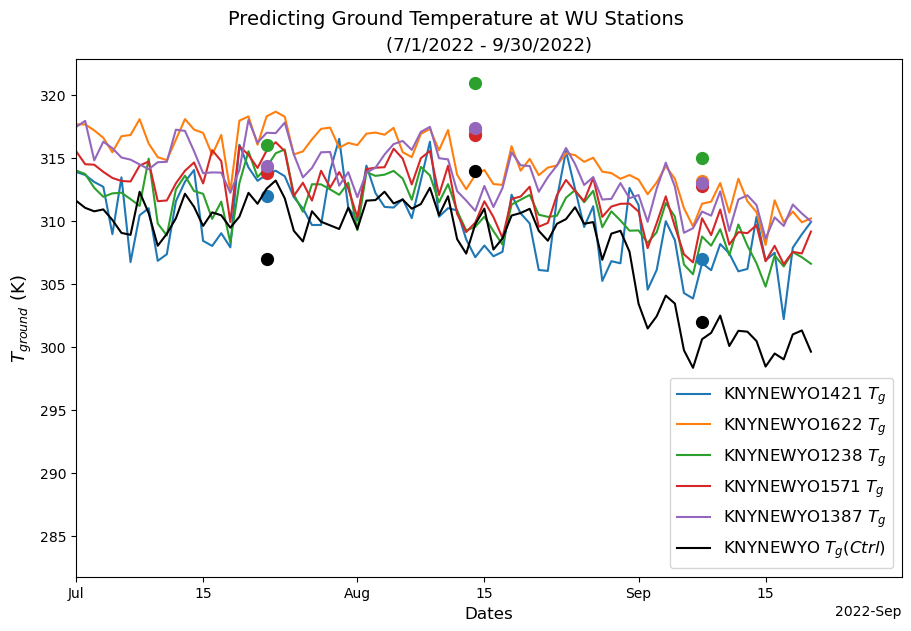

In [172]:
#plotting central park weather data
fig = plt.figure(constrained_layout=True)
fig = plt.figure(constrained_layout=True, figsize=(9,6.2))

ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[0]], markersize=2.5, label=r'KNYNEWYO'+wu_list[0]+' $T_g$')  
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[1]], markersize=2.5, label=r'KNYNEWYO'+wu_list[1]+' $T_g$') 
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[2]], markersize=2.5, label=r'KNYNEWYO'+wu_list[2]+' $T_g$')  
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[4]], markersize=2.5, label=r'KNYNEWYO'+wu_list[4]+' $T_g$')  
ax.plot(df_combo['DATE'], df_combo['T_ground_var'+wu_list[5]], markersize=2.5, label=r'KNYNEWYO'+wu_list[5]+' $T_g$') 
# close to Central Park (uptown - Harlem))
ax.plot(date_July, 312.0, 'o', color='tab:blue', markersize=8.5)  
ax.plot(date_July, 314.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_July, 316.0, 'o', color='tab:green', markersize=8.5) 
ax.plot(date_July, 313.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_July, 314.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_July, 307.0, 'ok', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 317.2, 'o', color='tab:blue', markersize=8.5)
ax.plot(date_August, 317.0, 'o', color='tab:orange', markersize=8.5)
# close to Central Park (uptown - Harlem))
ax.plot(date_August, 321.0, 'o', color='tab:green', markersize=8.5)
ax.plot(date_August, 316.8, 'o', color='tab:red', markersize=8.5)
ax.plot(date_August, 317.4, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_August, 314.0, 'ok', markersize=8.5)
ax.plot(date_September, 307.0, 'o', color='tab:blue', markersize=8.5)  
ax.plot(date_September, 313.2, 'o', color='tab:orange', markersize=8.5)
ax.plot(date_September, 315.0, 'o', color='tab:green', markersize=8.5) 
ax.plot(date_September, 312.8, 'o', color='tab:red', markersize=8.5) 
ax.plot(date_September, 313.0, 'o', color='tab:purple', markersize=8.5)
ax.plot(date_September, 302.0, 'ok', markersize=8.5)
ax.plot(df_combo['DATE'], df_combo['T_ground_ctrl_var'], '-k', markersize=2.5, label=r'KNYNEWYO $T_g (Ctrl)$')  
    
ax.set_xlabel("Dates", fontsize=12)
ax.set_ylabel(r"$T_{ground}$ (K)", fontsize=13)
plt.suptitle('Predicting Ground Temperature at WU Stations', fontsize=14)
ax.set_title('(7/1/2022 - 9/30/2022)', fontsize=13)
ax.set_xlim(July_1, Sept_30)
plt.legend(loc='lower right', fontsize=12)
plt.show()


In [173]:
#printing values for temp data on dates of interest (for historical comparison)
from datetime import timezone

dates_list = [date_July, date_August, date_September]
dates_list_str = [str(date_July), str(date_August), str(date_September)]

df_combo = df_combo.assign(DATE_datetime=df_combo['DATE'])
df_combo['DATE_datetime'] = df_combo['DATE_datetime'].astype(str)
df_combo['DATE_datetime'] = df_combo['DATE_datetime'].str.slice(0,19,1)

df_combo.loc[df_combo['DATE_datetime'].isin(dates_list_str)]

for i in range(len(wu_list_n)):
    print(df_combo.loc[df_combo['DATE_datetime'].isin(dates_list_str), 'T_ground_var'+wu_list_n[i]])
print(df_combo.loc[df_combo['DATE_datetime'].isin(dates_list_str), 'T_ground_ctrl_var'])


139    313.695830
162    307.128321
187    306.654197
Name: T_ground_var1421, dtype: float64
139    318.315028
162    313.662333
187    311.376985
Name: T_ground_var1622, dtype: float64
139    314.279312
162    309.543127
187    308.772095
Name: T_ground_var1238, dtype: float64
139    315.591301
162    309.877881
187    310.221596
Name: T_ground_var1571, dtype: float64
139    317.009555
162    310.811019
187    310.756037
Name: T_ground_var1387, dtype: float64
139    312.575108
162    309.754655
187    300.618507
Name: T_ground_ctrl_var, dtype: float64


In [175]:
# save the combined data frame including temperature data
# and model results to a csv file
df_combo.to_csv('NYC_Weather_Model_Data_03012022-09302022.csv')